In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# set plot size
plt.style.use({'figure.figsize':(25,25)})

plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号

In [2]:
df = pd.read_csv('housing.csv')
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PIRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


In [8]:
X = df.drop(['MEDV'],axis=1)
y = df['MEDV']

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1)

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid={
    'n_estimators':[5,10,20,50,100,200], #决策树的个数
    'max_depth':[3,5,7], #最大树深，树太深会造成过拟合
    'max_features':[0.6,0.7,0.8,1]#决策划分时考虑的最大特征数
}

#实例化随机森林回归器
rf=RandomForestRegressor()

#以随机森林回归器为基础构造网格搜索回归器
grid = GridSearchCV(rf,param_grid=param_grid,cv=3)

#在训练集上训练
grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [0.6, 0.7, 0.8, 1],
                         'n_estimators': [5, 10, 20, 50, 100, 200]})

### Select the best model 选取最优参数对应的模型

In [19]:
# check best model parameters
grid.best_params_
# 并非越多越好

{'max_depth': 7, 'max_features': 0.8, 'n_estimators': 50}

In [20]:
# 指定模型为效果最好参数对应的模型
rf_reg = grid.best_estimator_

In [22]:
rf_reg

RandomForestRegressor(max_depth=7, max_features=0.8, n_estimators=50)

### Visualize one of the tree

In [23]:
from sklearn import tree
import pydotplus
from IPython.display import Image,display

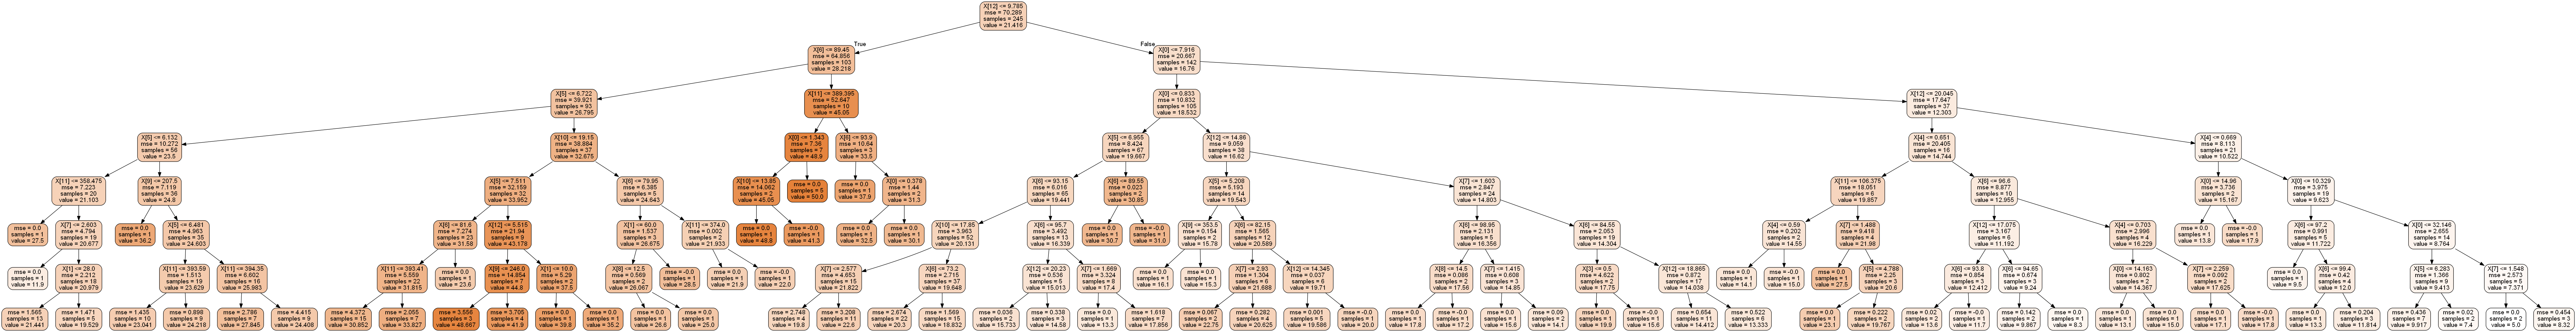

In [24]:
estimator=rf_reg.estimators_[5]
dot_data=tree.export_graphviz(estimator,
                              out_file=None,
                              filled=True,
                              rounded=True
                             )
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

### 特征重要度分析 Feature Imporance Analysis

In [25]:
rf_reg.feature_importances_

array([4.30141729e-02, 1.08485354e-03, 8.40005190e-03, 4.40128469e-04,
       3.10135253e-02, 2.04150625e-01, 3.50162456e-02, 5.52167700e-02,
       1.96010346e-03, 1.63366094e-02, 4.22074366e-02, 1.48004961e-02,
       5.46358982e-01])

In [26]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PIRATIO', 'B', 'LSTAT'],
      dtype='object')

In [29]:
import numpy as np
print("Feature Importance Order:")
feature_names=X.columns
feature_importances=rf_reg.feature_importances_
indices=np.argsort(feature_importances)[::-1]

for index in indices:
    print("feature %s(%f)"%(feature_names[index],feature_importances[index]))

Feature Importance Order:
feature LSTAT(0.546359)
feature RM(0.204151)
feature DIS(0.055217)
feature CRIM(0.043014)
feature PIRATIO(0.042207)
feature AGE(0.035016)
feature NOX(0.031014)
feature TAX(0.016337)
feature B(0.014800)
feature INDUS(0.008400)
feature RAD(0.001960)
feature ZN(0.001085)
feature CHAS(0.000440)


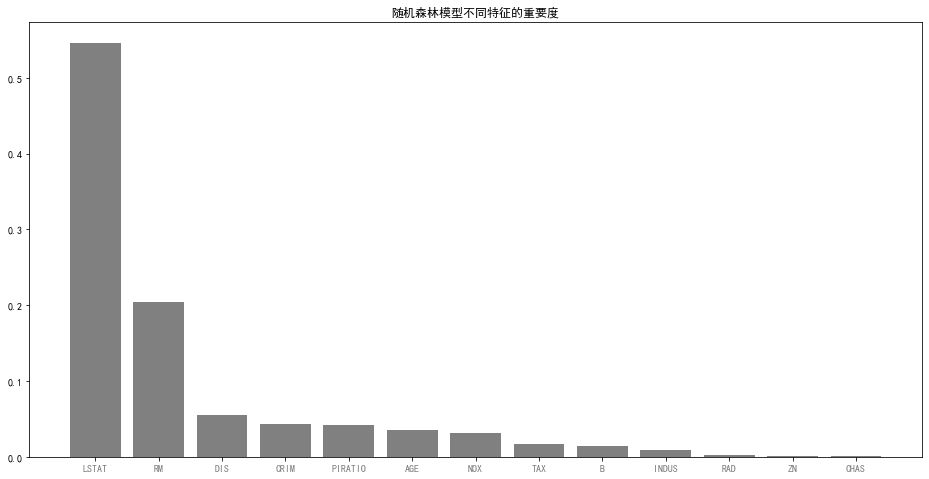

In [32]:
plt.figure(figsize=(16,8))
plt.title("随机森林模型不同特征的重要度")
plt.bar(range(len(feature_importances)),feature_importances[indices],color='gray')
plt.xticks(range(len(feature_importances)),np.array(feature_names)[indices],color='gray')
plt.show()

### Visualize regression results on testing dataset

In [35]:
result = {"label":y_test,"prediction":rf_reg.predict(X_test)}
result = pd.DataFrame(result)

In [36]:
result.head()

,label,prediction
307,28.2,30.631174
343,23.9,26.908658
47,16.6,20.238337
67,22.0,20.869468
362,20.8,19.701126


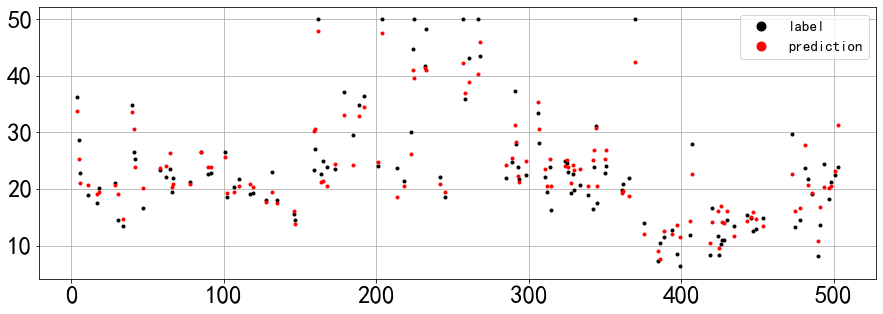

In [38]:
result['label'].plot(style='k.',figsize=(15,5))
result['prediction'].plot(style='r.')
#设置图里文字大小和图示大小
plt.legend(fontsize=15,markerscale=3)
#设置坐标文字大小
plt.tick_params(labelsize=25)
#生成刻度线网络
plt.grid()

### MSE & RMSE

In [39]:
from sklearn import metrics
MSE = metrics.mean_squared_error(y,rf_reg.predict(X))
MSE

4.606530140558959

In [40]:
np.sqrt(MSE)

2.1462828659240047

In [41]:
submission={"prediction":rf_reg.predict(X_test)}
submission=pd.DataFrame(submission)
submission.head()

,prediction
0,30.631174
1,26.908658
2,20.238337
3,20.869468
4,19.701126


In [42]:
submission.to_csv("submission.csv")